## Final Project Submission

Please fill out:
* Student name: Kevin Spring
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Morgan Jones
* Blog post URL:

# Business Problem
Our clients is a residential real estate broker in King County, WA interested in finding a solution for their clients. Many of their clients come to them needing to sell their home but are unsure of the price to list. The real estate broker wants us to design and implement a model where they can take in the attributes of their client's home and determine which price to begin listing discussion with their client.

## Stakeholders
- President of brokerage firm
- Real estate agents that will use the dashboard

# Summary of Recommendations

# Methods

This analysis uses regression analysis to make predictions. Specifically, given certain features of a home, output a price range would this house be sold?

- Import Data and Dependencies
- Get Data
    - Import
    - Clean data
    - Ensure continuous data
    - Encode catagorical data
    - Separate data into training and testing datasets
- Build Regression Model
    - Specify Model
        - Which independent variables belong in the model?
        - Are we modeling curvature and interactions?
        - Identify statistically significant relationship
    - Build Model and check
    - Check residual plots
    - Interpret confidence interval and prediction intervala
    
- Evaluate Regression Model for making predicitons
- Check data structure and test if it meets assumtions for regression analysis
- Standardize and/or Transformation
- Ensure data structure meets assumptions
-  between the v
- 
- Make predictions

## Import Libraries and Data
### Materials

In [1]:
# Import libraries
from datetime import date

## Data analysis
import pandas as pd
import numpy as np

## Statistical analysis
import statsmodels.formula.api as smf  
from statsmodels.formula.api import ols

## Model Building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Exploratory Data Analysis and Clean-up

Strategy:
- Look for duplciated and missing data.
- 

In [2]:
# import and inspect data
df = pd.read_csv('data/kc_house_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Column Names and Descriptions for King County Data Set
* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors


## Identify and remove duplicated records

In [4]:
# Any dulplicated homes?
duplicates_len = len(df[df.duplicated(subset=['id'], keep=False)].sort_values(by='id'))
print(f"There are {duplicates_len} duplicated records.")
df[df.duplicated(subset=['id'], keep=False)].sort_values(by='id').head(6)
#df[df['id'] == 1000102]

There are 353 duplicated records.


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2495,1000102,4/22/2015,300000.0,6,3.00,2400,9373,2.0,NO,NONE,...,7 Average,2400,0.0,1991,0.0,98002,47.3262,-122.214,2060,7316
2494,1000102,9/16/2014,280000.0,6,3.00,2400,9373,2.0,NaN,NONE,...,7 Average,2400,0.0,1991,0.0,98002,47.3262,-122.214,2060,7316
16800,7200179,10/16/2014,150000.0,2,1.00,840,12750,1.0,NO,NONE,...,6 Low Average,840,0.0,1925,0.0,98055,47.4840,-122.211,1480,6969
16801,7200179,4/24/2015,175000.0,2,1.00,840,12750,1.0,NO,NONE,...,6 Low Average,840,0.0,1925,NaN,98055,47.4840,-122.211,1480,6969
11422,109200390,10/20/2014,250000.0,3,1.75,1480,3900,1.0,NO,NONE,...,7 Average,1480,0.0,1980,0.0,98023,47.2977,-122.367,1830,6956
11421,109200390,8/20/2014,245000.0,3,1.75,1480,3900,1.0,NO,NONE,...,7 Average,1480,0.0,1980,0.0,98023,47.2977,-122.367,1830,6956


### Duplicate home ID discussion
The duplicated records based on ID look like they are the same home that wold within the same year as they have the same attributes except for sale `date`. These may be homes that were flipped or sold quickly after. I will keep these records as I am interested in predicting a home's sale price and these sales of the same home can act as replicates improving my model.

## Unnecessary variables
The following variables will be deleted from this analysis as they are unnecessary
- `id` - This is an unique identifier for each home. As it is too specific it will be deleted.
- `date` - This is the sale date and is not needed as all the homes were sold between 2014 to 2015.
- `lat` - This is the latitude of the home sold. As it is too specific for the home it will be deleted
- `long` - same reasoning as `lat`

In [5]:
df.drop(['id','date', 'lat', 'long'], axis=1, inplace=True)

## Missing data

In [6]:
# How many columns have NaN?
print(df.isna().sum())

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
sqft_living15       0
sqft_lot15          0
dtype: int64


In [7]:
# Any placeholders?
# Look for top occuring values
print('King County, WA \n Home Sales Dataframe\n')
for col in df.columns:
    print(col, '\n', df[col].value_counts(normalize = True).head(10), '\n')

King County, WA 
 Home Sales Dataframe

price 
 450000.0    0.007964
350000.0    0.007964
550000.0    0.007362
500000.0    0.007038
425000.0    0.006945
325000.0    0.006853
400000.0    0.006714
375000.0    0.006390
300000.0    0.006158
525000.0    0.006066
Name: price, dtype: float64 

bedrooms 
 3     0.454878
4     0.318655
2     0.127796
5     0.074131
6     0.012594
1     0.009075
7     0.001760
8     0.000602
9     0.000278
10    0.000139
Name: bedrooms, dtype: float64 

bathrooms 
 2.50    0.248970
1.00    0.178312
1.75    0.141131
2.25    0.094782
2.00    0.089364
1.50    0.066907
2.75    0.054869
3.00    0.034866
3.50    0.033847
3.25    0.027272
Name: bathrooms, dtype: float64 

sqft_living 
 1300    0.006390
1400    0.006251
1440    0.006158
1800    0.005973
1660    0.005973
1010    0.005973
1820    0.005927
1480    0.005788
1720    0.005788
1540    0.005742
Name: sqft_living, dtype: float64 

sqft_lot 
 5000    0.016576
6000    0.013428
4000    0.011622
7200    0.010187
480

### Missing value results
- `NaN`
    - `waterfront`
    - `view`
    - `yr_renovated`
- Placeholder
    - `yr_renovated` has `0` for missing or unknown values.
    - `sqft_basement` has `?` for missing or unknown values.

### Strategy for replaceing missing values
- `waterfront`
    - Binary categorical variable (`YES` or `NO`)
    - replace `NaN` with mode of `NO` as most likely these properties are not waterfront.
- `yr_renovated`
    - Catagorical variable
    - `0` is the most common value with over 95% of values. 
    - Replace `NaN` with 0 value
- `view`
    - Ordinal categorical variable
    - replace `NaN` with `NONE` 

In [8]:
# replacing waterfront NaN with 'NO'
df['waterfront'].fillna('NO', inplace=True)

# replace yr_renovated NaN with 'Unknown'
df['yr_renovated'].fillna(0, inplace=True)

# replace `Nan` with `NONE` for column `view`
df['view'].fillna('NONE', inplace=True)

In [9]:
# How many columns have NaN?
print(df.isna().sum())

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
sqft_living15    0
sqft_lot15       0
dtype: int64


### Strategy for data cleanup
- `condition`
    - Ordinal categorical variable
    - dictionary - `{'Poor': 0, 'Fair': 1, 'Average': 2, 'Good': 3, 'Very Good': 4}`
- `grade`
    - Ordinal categorical variable
    - Example: `7 Average`
    - Delete the descriptor, keep the number, and convert it to `int` datatype.
- `sqft_basement`
    - `?` makes up about 2% of values and the current value of `0` makes up almost 60%.
    - Since it is a low value I will replace `?` with the mode of `0`.
    - If there is a basement the value will be set to `1` making this a binary variable.
- `view`
    - Oridinal catagorical variable
    - dicitonary - `{'NONE': 0, 'FAIR': 1, 'AVERAGE': 2, 'GOOD': 3, 'EXCELLENT': 4}`
- `waterfront`
    - Binary catagorical variable
    - dictionary - `'NO': 0, 'YES': 1`
- `home_age`
    - Create new catagorical variable
    - subtract current year from `yr_built`
    - Drop `yr_built`
- `yr_since_reno`
    - Make new variable  
    - Subtract current year from `yr_renovated`
        -  `0` is the most common value with over 95% of values.
        - if never renovated then subtract from `yr_built`
    - Drop `yr_renovated`

In [11]:
# condition: Map condition variable to dictionary
condition_dict = {'Poor': 0, 'Fair': 1, 'Average': 2, 
                  'Good': 3, 'Very Good': 4}
df['condition'] = df['condition'].map(condition_dict)

# grade: strip out by spaces and keep the first string, which should be the number
df['grade'] = df['grade'].apply(lambda x: x.split(' ', 1)[0]).astype(int)

# sqft_basement has '?' as a placeholder. Set this to 0.
df['sqft_basement'].replace('?', 0, inplace=True)
df['sqft_basement'] = df['sqft_basement'].astype(float)
df['sqft_basement'].loc[df['sqft_basement'] > 0] = 1
df.rename(columns={'sqft_basement': 'basement'}, inplace=True)

# view: Map condition variable to dictionary
view_dict = {'NONE': 0, 'FAIR': 1, 'AVERAGE': 2, 
                  'GOOD': 3, 'EXCELLENT': 4}
df['view'] = df['view'].map(view_dict)
df.head()

# waterfront: Map binary variable to dictionary
waterfront_dict = {'NO': 0, 'YES': 1}
df['waterfront'] = df['waterfront'].map(waterfront_dict)

# home_age 
current_year = date.today().year
df['home_age'] = current_year - df['yr_built']
df.drop('yr_built', axis=1, inplace=True)

# yr_since_reno
# subtraction function
def sub(a, b):
    return a - b

df['yr_since_reno'] = df.apply(lambda row : sub(current_year, row['yr_renovated']) if row['yr_renovated'] > 0 else row['home_age'], axis = 1)
df.drop('yr_renovated', axis=1, inplace=True)


D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [12]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,basement,zipcode,sqft_living15,sqft_lot15,home_age,yr_since_reno
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.00000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.006760,0.233181,2.409825,7.657915,1788.596842,0.38510,98077.951845,1986.620318,12758.283512,51.000324,49.054869
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.081944,0.764673,0.650546,1.173200,827.759761,0.48663,53.513072,685.230472,27274.441950,29.375234,28.945393
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,0.000000,3.000000,370.000000,0.00000,98001.000000,399.000000,651.000000,7.000000,7.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,2.000000,7.000000,1190.000000,0.00000,98033.000000,1490.000000,5100.000000,25.000000,23.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,2.000000,7.000000,1560.000000,0.00000,98065.000000,1840.000000,7620.000000,47.000000,45.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,3.000000,8.000000,2210.000000,1.00000,98118.000000,2360.000000,10083.000000,71.000000,68.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,4.000000,13.000000,9410.000000,1.00000,98199.000000,6210.000000,871200.000000,122.000000,122.000000


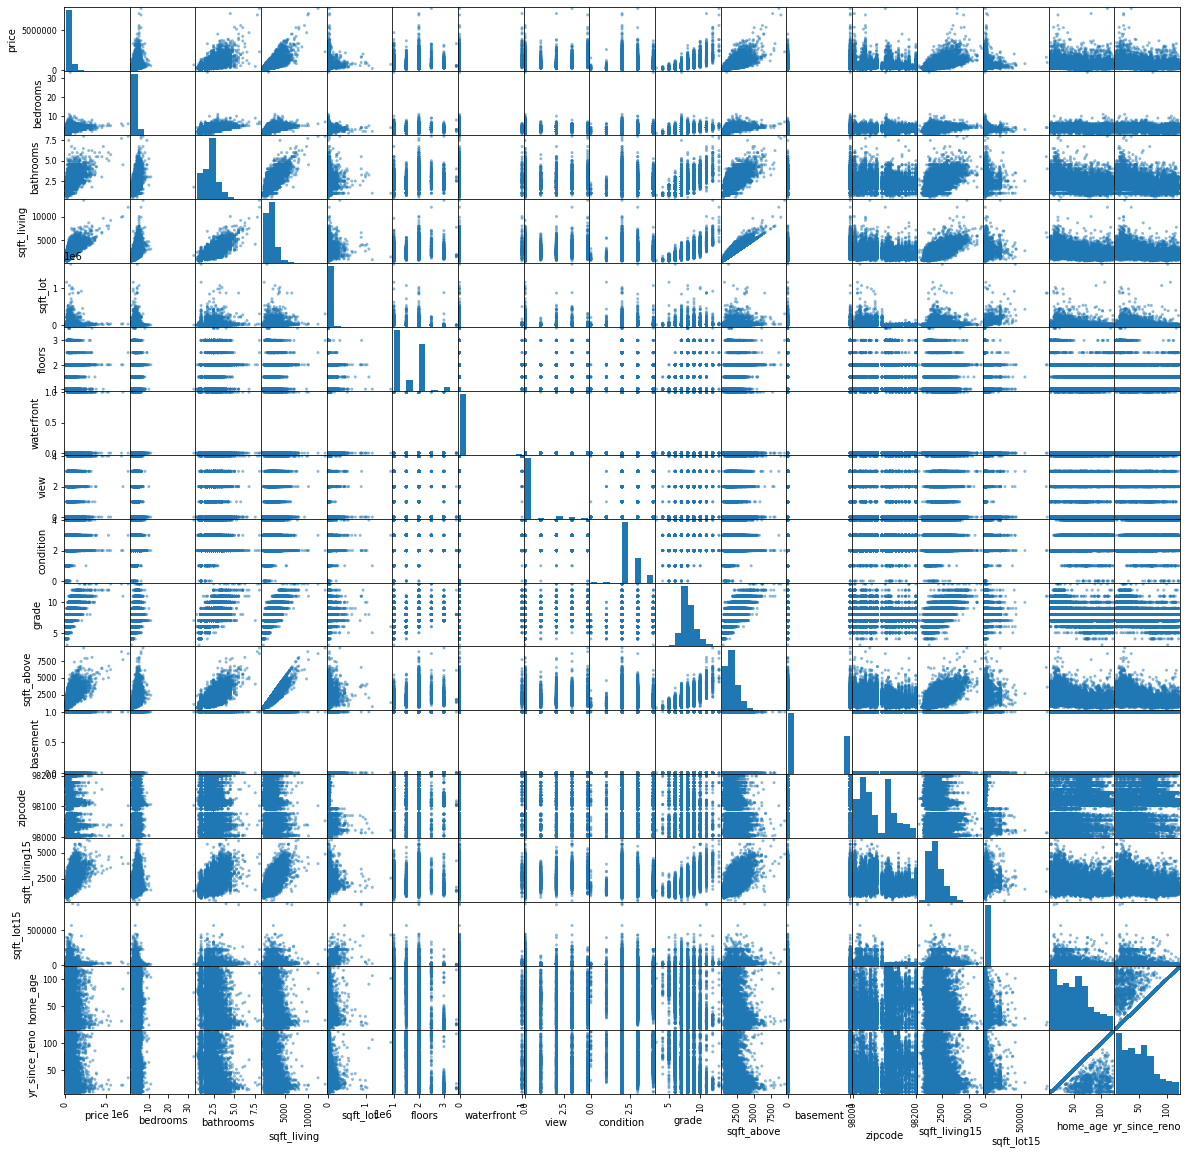

In [13]:
import warnings
warnings.filterwarnings('ignore')

# Visualize the data using scatter plot and histogram
pd.plotting.scatter_matrix(df, figsize  = [20, 20]);
plt.show()
#sns.set_palette('colorblind')
#sns.pairplot(data=df, height=5)

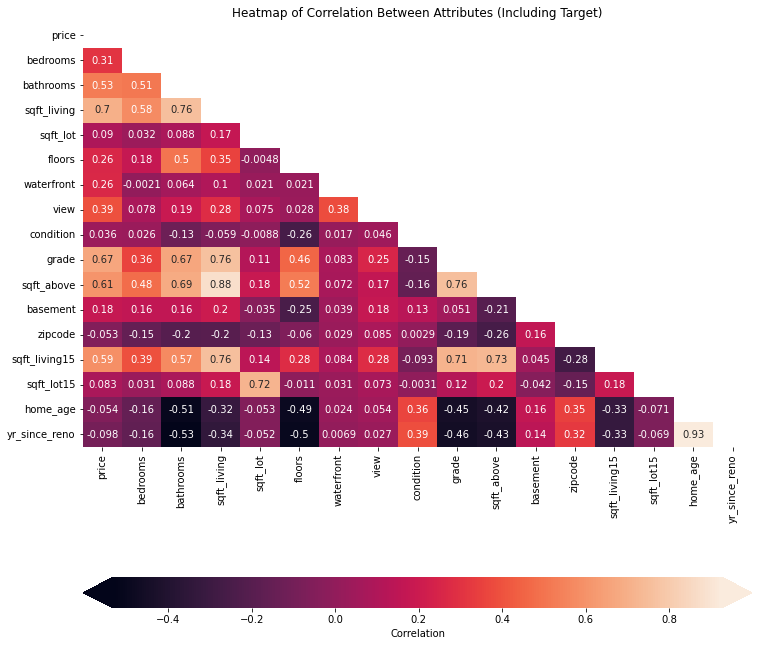

In [14]:
# Make heatmap 

# compute the correlation matrix
corr = df.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(12, 12))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [16]:
features = []
correlations = []
for idx, correlation in corr['price'].T.iteritems():
    if correlation >= .30 and idx != 'price':
        features.append(idx)
        correlations.append(correlation)
corr_with_price = pd.DataFrame({'Correlations':correlations, 'Features': features})

Multicollinear_Features = []
Multicollinear_Corr = []
def check_multicollinearity(feature):
    for idx, correlation in corr[feature].T.iteritems():
        if correlation >= .75 and idx != feature:
            Multicollinear_Features.append([feature, idx])
            Multicollinear_Corr.append(correlation)
            
for feature in corr:
    check_multicollinearity(feature)
MC_df = pd.DataFrame({'Correlations':Multicollinear_Corr, 'Features': Multicollinear_Features})
print('Multicollinear Features')
display(MC_df)
print('Correlations with Price')
display(corr_with_price)

Multicollinear Features


,Correlations,Features
0,0.755758,"[bathrooms, sqft_living]"
1,0.755758,"[sqft_living, bathrooms]"
2,0.762779,"[sqft_living, grade]"
3,0.876448,"[sqft_living, sqft_above]"
4,0.756402,"[sqft_living, sqft_living15]"
5,0.762779,"[grade, sqft_living]"
6,0.756073,"[grade, sqft_above]"
7,0.876448,"[sqft_above, sqft_living]"
8,0.756073,"[sqft_above, grade]"
9,0.756402,"[sqft_living15, sqft_living]"


Correlations with Price


,Correlations,Features
0,0.308787,bedrooms
1,0.525906,bathrooms
2,0.701917,sqft_living
3,0.393497,view
4,0.667951,grade
5,0.605368,sqft_above
6,0.585241,sqft_living15


## Variables to use
- sqft_living
- sqft_living15
- grade
- view
- bedrooms
- bathrooms

In [19]:
# Drop condition, view, waterfront, sqft
features = ['price', 'grade', 'bathrooms', 'sqft_living15', 'sqft_living']
df_clean = df[features].copy()

### Multicollinearity
- Use Variance Inflation Factor (VIF)
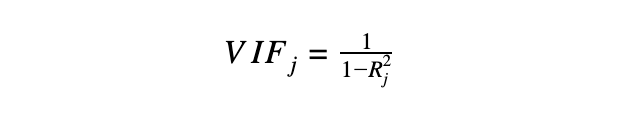

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['feature'] = df_clean.drop(columns='price').columns
vif_data['VIF'] = [variance_inflation_factor(df_clean.values, i)
                    for i in range(len(df_clean.columns)-1)]
print(vif_data)

         feature        VIF
0          grade   6.255294
1      bathrooms  23.830982
2  sqft_living15  21.148638
3    sqft_living  24.595663


### Encode catagorical data

In [ ]:
# Convert to Dummy variables
cat_col = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'zipcode', 'grade']
#cat_col = ['bedrooms', 'bathrooms']

# label columns as category
df[cat_col] = df[cat_col].astype('category')
ohe_df = pd.get_dummies(df[cat_col].drop(columns='grade'), drop_first=True) #encode

# extract continunous features from original df
cont_df = df.select_dtypes(include='number')
#cont_col = ['sqft_living', 'price']
#cont_df = df[cont_col].copy()

# merge both num_col and one_hot_encoder_df
df_clean = pd.concat([cont_df, df['grade'], ohe_df], axis=1)
df_clean.head()

In [ ]:
import pandas as pd
from statsmodels.graphics.factorplots import interaction_plot

# make interaction plot
interaction_plot(df_clean['sqft_living'], df_clean['grade'], np.log(df['price']))

## Standardize and Normalize data
https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94



In [ ]:
#histogram and normal probability plot

from scipy.stats import norm
from scipy import stats

# histogram
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
sns.distplot(df_clean['price'], fit=norm, bins=30, kde=False, ax=ax1);
res = stats.probplot(df_clean['price'], plot=ax2)

# This shows a right-skewed distribution
## https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de
print("Skewness: %f" % df_clean['price'].skew()) # Data is highly skewed
print("Kurtosis: %f" % df_clean['price'].kurt()) # leptokurtic (>3)

In [ ]:

# log transform price data
df_clean['price_log'] = np.log(df_clean['price'])

# histogram
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
sns.distplot(df_clean['price_log'], fit=norm, bins=30, kde=False, ax=ax1);
res = stats.probplot(df_clean['price_log'], plot=ax2)

# This shows a right-skewed distribution
## https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de
print("Skewness: %f" % df_clean['price_log'].skew()) # Data is not skewed
print("Kurtosis: %f" % df_clean['price_log'].kurt()) # leptokurtic (>3)

In [ ]:
from sklearn.preprocessing import PowerTransformer

# Transform the rest of the continuous right-skewed variables
df_clean['sqft_living_log'] = np.log(df_clean['sqft_living'])

#histogram and normal probability plot for log transformed price data
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
sns.distplot(df_clean['sqft_living_log'], fit=norm, bins=30, kde=False, ax=ax1);
res = stats.probplot(df_clean['sqft_living_log'], plot=ax2)

# This shows a right-skewed distribution
## https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de
print("Skewness: %f" % df_clean['sqft_living_log'].skew()) # Data is not skewed
print("Kurtosis: %f" % df_clean['sqft_living_log'].kurt())

In [ ]:
## Build a simple model
# y = m * x + b
# sales price = m * sqft + b(error)

# Split data into train-test-split
#feature_cols = 'sqft_living'
y = df_clean[['price_log']]
X = df_clean.drop(columns=['price_log', 'price', 'sqft_living'])
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2)

# Residual plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
ax1.scatter(X['grade'], y)
sns.residplot(x=X['grade'], y = y, ax=ax2) # slight upward pattarn

# Make linear model 
reg = LinearRegression().fit(x_train, y_train)
print(reg.intercept_)
print(reg.coef_) # for an increase of e^1 square meter in house size,
# the house price will go up by e^0.84, on average

### Strategy for normalization
- Log transform
    - `price`
    - `sqft_living`
    - `sqft_above`
    - `sqft_basement`
    - `sqft_lot`
    - `sqft_living15`
    - `sqft_log15`

### Transform sqft_living

In [ ]:
from sklearn.preprocessing import PowerTransformer

# Transform the rest of the continuous right-skewed variables
to_log = ["sqft_living15"]
#to_log = ['sqft_living']
X['sqft_living15_log'] = np.log(df[to_log].copy())
X.drop(columns=['sqft_living15'], inplace=True)

fig = plt.figure(figsize = (12,12))
ax = fig.gca()
X['sqft_living15_log'].hist(ax = ax);

### Log Transformation results
Price and sqft of the home can be normalized with log transformation except for `sqft_basement` which has many 0 values becuase some homes do not have a basement. This variable will be dropped.

In [ ]:
df.drop('sqft_basement', axis=1, inplace=True)
df.info()


# Model building

In [ ]:
X.head()

In [ ]:
# Split data into train and test data
# y as above
#X = df[['sqft_living', 'sqft_living15', 'grade', 'bathrooms']]

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2) #80% training

Model_1 = smf.ols(formula="price ~ grade + bathrooms + sqft_living15  + sqft_living", data=df).fit()
Model_1.summary()

In [ ]:

# Residual plot
#fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
#ax1.scatter(X, y)
#sns.residplot(x=X, y = y, ax=ax2) # indicates impure heteroskedactity

# Make linear model 
reg = LinearRegression().fit(X_train, y_train)
print(reg.intercept_)
print(reg.coef_) 

In [ ]:
reg.score(X_train, y_train)